In [1]:
import sys
sys.path.append("../") 

import numpy as np
import scipy.linalg as slin
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import LISA as l

import Wavelet as wv
import Glitch as gl
import Burst as bu
import Burst_Slow as buS
import MCMC_tools as mct

# constants
mHz = 1.0e-3
Hour = 3600.

In [2]:
Week = 3600.*24.*7.
dt   = 15.
Tobs = 2**np.ceil(np.log2(Week/dt))*dt

# print(np.log2(Tobs/dt))
# print(Tobs/dt)

# set up the LISA orbit
orb = l.Orbit(Tobs, dt=dt)
t = np.arange(0.0, orb.Tobs, orb.dt) # set up the time of this orbit
h = np.zeros(len(t))

print("Nyquist Freq........ {} mHz".format(orb.f_ny*1000.))

# set up parameters of wavelet
A    = 2.0e-21
f0   = 3.0*mHz
tau  = 1.5*Hour
t0   = 0.5*orb.Tobs
phi0 = 1.0
Q = 2*np.pi*f0*tau

print("Q................... {}".format(Q))
print("tau................. {} s".format(tau))
print("dt.................. {} s".format(orb.dt))

wave = wv.Wavelet(A, f0, tau, t0, phi0, orb)
wave.calc_Psi()
wave.make_padded_Psi(t) # drop in the wavelet time series into the data stream
h = h + wave.Psi_padded

Nyquist Freq........ 33.333333333333336 mHz
Q................... 101.7876019763093
tau................. 5400.0 s
dt.................. 15.0 s


In [3]:
# set up parameters of wavelet
epsil = 0. # polarization parameter

wave2 = wv.Wavelet(epsil*A, f0, tau, t0, phi0, orb)
wave2.calc_Psi()
wave2.make_padded_Psi(t)

# sky angles and polarization angles.
phi   = np.pi
theta = np.pi*3/4
psi   = np.pi*0.2

# gw = bu.GW_glitch(wave, wave2, theta, phi, psi, orb, Flag_fast)
# gw.construct_detector_tensor()
# gw.calculate_strain()
# if (Flag_fast == 0):
#     tdi_GW = gw.construct_TDI(t, orb)
# else:
#     tdi_GW = gw.construct_TDI_FAST(orb)

gw_slow = buS.GW_glitch(wave, wave2, theta, phi, psi, orb)
gw_slow.construct_detector_tensor()
gw_slow.calculate_strain()
tdi_GW_slow = gw_slow.construct_TDI(t, orb)

In [4]:
A    = 2.0e-21
f0   = 3.0*mHz
tau  = 1.5*Hour
t0   = 0.5*orb.Tobs
phi0 = 1.0

theta = np.pi*3/4
phi   = np.pi*1.
psi   = np.pi*0.2
ellip = 0.

# Non-Dimensional parameters
paramsND = np.array([np.log(A), f0/mHz, t0/Week, tau/Week, phi0, \
                     np.cos(theta), phi, psi, ellip])

gw = bu.Burst(paramsND, orb)
gw.construct_detector_tensor()
gw.calculate_strain()
gw.TDI = gw.construct_TDI(orb)

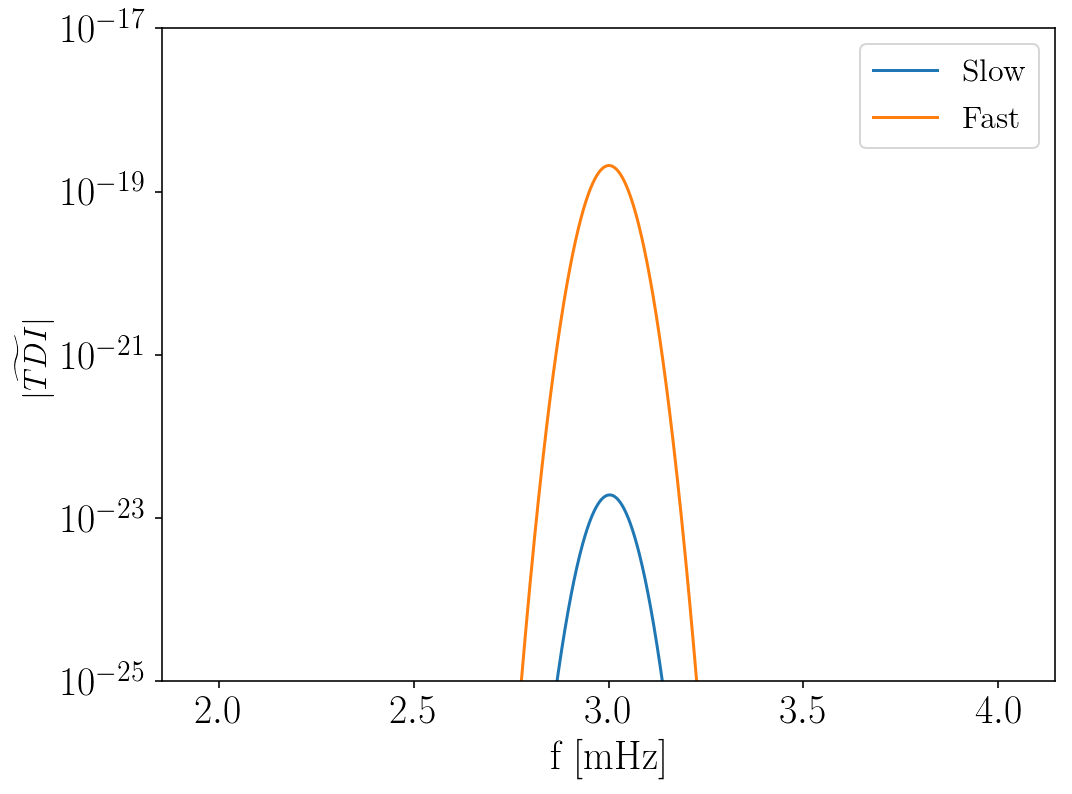

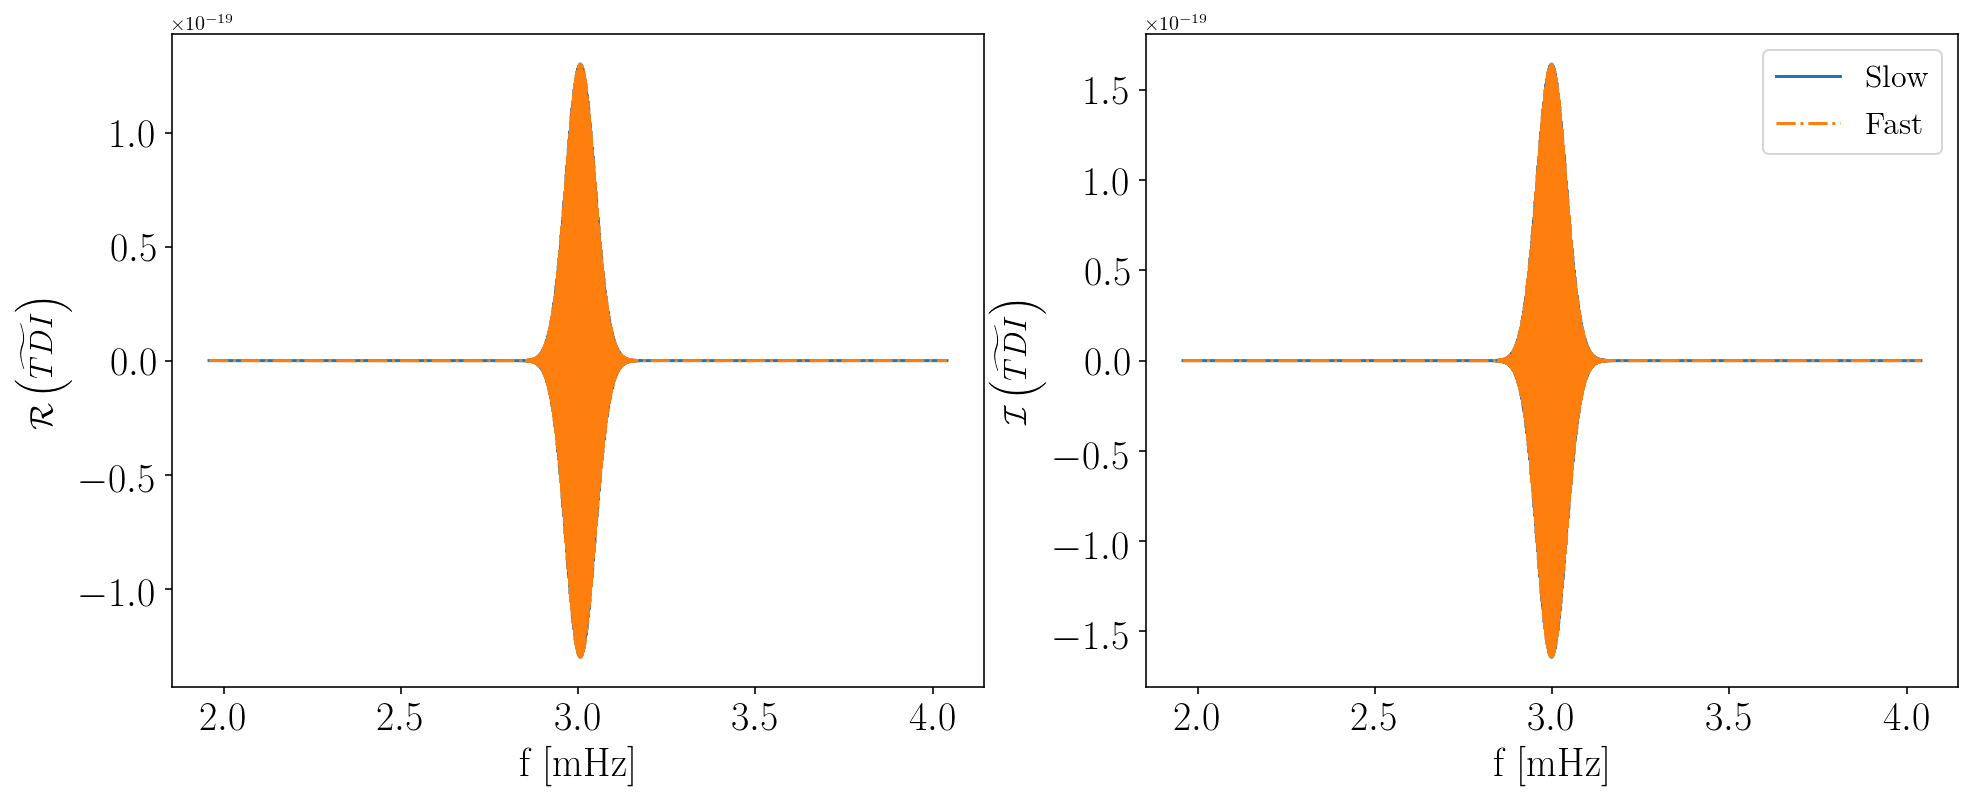

In [5]:
fig, ax = plt.subplots(figsize=(8,6))

ax.set_xlabel(r'f [mHz]', fontsize=20)
ax.set_ylabel(r'$|\widetilde{TDI}|$', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=20)

# find an appropriate frequency range
mask = (tdi_GW_slow.freqs >= gw.TDI.freqs[0]) & (tdi_GW_slow.freqs <= gw.TDI.freqs[-1])
f = 1000*gw.TDI.freqs

ax.set_ylim(1.0e-25, 1.0e-17)
ax.semilogy(f, np.abs(tdi_GW_slow.T[mask]), label='Slow')
ax.semilogy(f, np.abs(gw.TDI.X), label='Fast')

plt.legend(loc='upper right', fontsize=16)
plt.show()

# Now plot the real and imaginary parts
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(2*8,6))

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_xlabel(r'f [mHz]', fontsize=20)
ax[0].set_ylabel(r'$\mathcal{R}\left(\widetilde{TDI}\right)$', fontsize=16)

ax[0].plot(f, tdi_GW_slow.X[mask].real, label='Slow')
ax[0].plot(f, gw.TDI.X.real, label='Fast', linestyle='-.')

ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_xlabel(r'f [mHz]', fontsize=20)
ax[1].set_ylabel(r'$\mathcal{I}\left(\widetilde{TDI}\right)$', fontsize=16)

ax[1].plot(f, tdi_GW_slow.X[mask].imag, label='Slow')
ax[1].plot(f, gw.TDI.X.imag, label='Fast', linestyle='-.')

# ax[0].set_xlim(f[0]*1.015, f[-1]*0.987)
# ax[1].set_xlim(f[0]*1.015, f[-1]*0.987)


plt.legend(loc='upper right', fontsize=16)
plt.show()

In [6]:
gw.calc_snr()
gw.adjust_snr(10)
gw.calc_Fish()

# M,N = gw.Fisher.shape
# U,s,Vh = slin.svd(gw.Fisher)
# Sig = slin.diagsvd(s,M,N)

# for i in range(len(Sig)):
#     if (Sig[i,i] < 0.01):
#         Sig[i,i] = 0.
        
# SigI = np.zeros((len(Sig),len(Sig)))
# for i in range(len(Sig)):
#     if (Sig[i,i] != 0.0):
#         SigI[i,i] = 1/Sig[i,i]
        
# invFish = Vh.transpose().dot(SigI.dot(U.transpose()))

# invFish = slin.inv(U.dot(Sig.dot(Vh)))

print("Numeric Fisher Estimates")
invFish = slin.inv(gw.Fisher)
print("-------------------------------")
print("A error............ {} %"      .format( 100*np.sqrt(invFish[0,0]) ))
print("f0 error........... {} mHz"    .format(     np.sqrt(invFish[1,1])*mHz ))
print("t0 error........... {} minutes".format(     np.sqrt(invFish[2,2])*Week/60 ))
print("tau error.......... {} minutes".format(     np.sqrt(invFish[3,3])*Week/60 ))
print("phi0 error......... {}"        .format(     np.sqrt(invFish[4,4]) ))
print()
print("cos theta error.... {}"        .format(     np.sqrt(invFish[5,5]) ))
print("phi error.......... {}"        .format(     np.sqrt(invFish[6,6]) ))
print("psi error.......... {}"        .format(     np.sqrt(invFish[7,7]) ))
print("ellip error........ {}"        .format(     np.sqrt(invFish[8,8]) ))
print()

Numeric Fisher Estimates
-------------------------------
A error............ 4935.446691503404 %
f0 error........... 5.95880591177482e-06 mHz
t0 error........... 80.87969340839507 minutes
tau error.......... 12.737850290447636 minutes
phi0 error......... 10.672648198635555

cos theta error.... 9.047934217101567
phi error.......... 4.789055983063729
psi error.......... 6560.847279430462
ellip error........ 13121.697898255808



In [7]:
M,N = gw.Fisher.shape
U,s,Vh = slin.svd(gw.Fisher)
Sig = slin.diagsvd(s,M,N)

print('Condition number........ {}'.format(np.log2(np.max(Sig)/np.min(np.diag(Sig)))))

for i in range(len(Sig)):
    if (Sig[i,i] < 0.1):
        Sig[i,i] = 0.
        
Fish_nonsing = U.dot(Sig.dot(Vh))

Condition number........ 61.28013516876984


In [8]:
e_vals, e_vecs = mct.get_Fisher_Eignen_BS(Fish_nonsing)

In [9]:
%%timeit
gw = bu.Burst(paramsND, orb)
gw.construct_detector_tensor()
gw.calculate_strain()
gw.TDI = gw.construct_TDI(orb)

2.42 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Make a figure of GW burst at some point

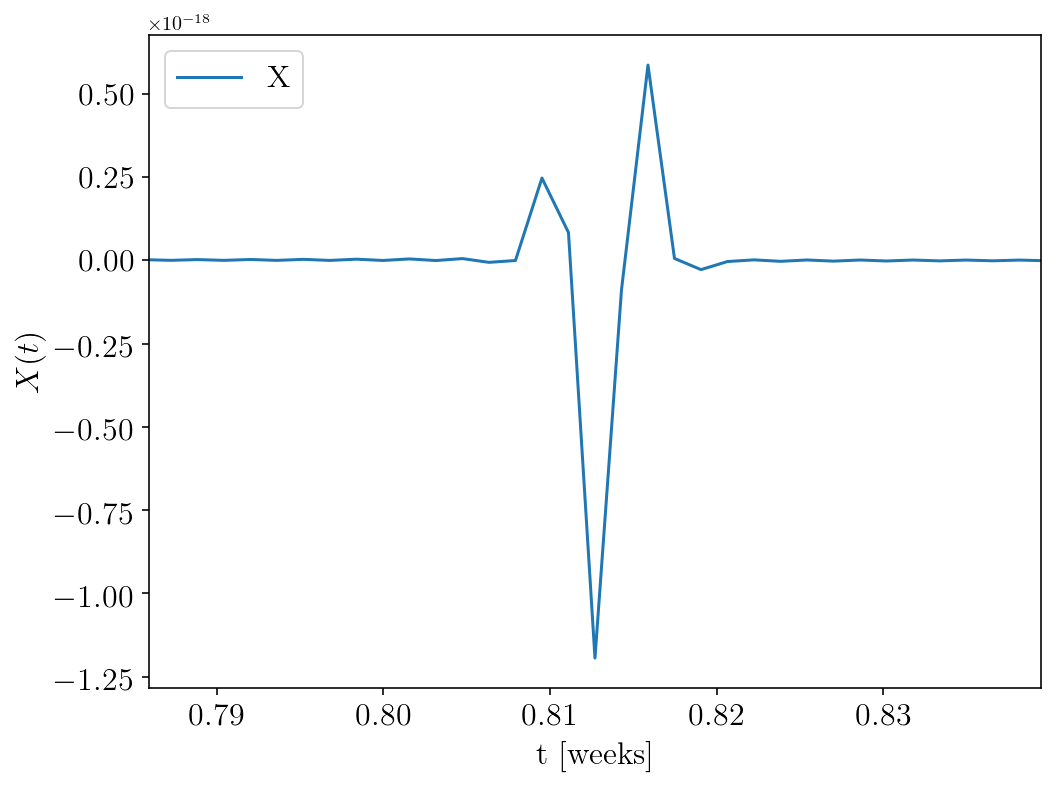

In [32]:
dt   = 15.
orb = l.Orbit(Tobs, dt=dt/4)
t = np.arange(0.0, orb.Tobs, orb.dt) # set up the time of this orbit
h = np.zeros(len(t))

A    = 2.0e-21
f0   = 20.0*mHz
tau  = 0.5*Hour
t0   = 0.5*orb.Tobs
phi0 = 1.0

theta = np.pi*3/4
phi   = np.pi*1.
psi   = np.pi*0.2
ellip = 0.

# Non-Dimensional parameters
paramsND = np.array([np.log(A), f0/mHz, t0/Week, tau/Week, phi0, \
                     np.cos(theta), phi, psi, ellip])

gw = bu.Burst(paramsND, orb)
gw.construct_detector_tensor()
gw.calculate_strain()
gw.TDI = gw.construct_TDI(orb)

X_time_dom = np.fft.irfft(gw.TDI.X)

N = len(X_time_dom)
dt = Tobs/N
t = np.arange(0, Tobs, dt)

fig, ax = plt.subplots(1, figsize=(8,6))

ax.set_xlabel(r't [weeks]', fontsize=16)
ax.set_ylabel(r'$X(t)$', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=16)

plt.xlim((wave.t0 - 3.*wave.tau)/Week, (wave.t0 + 3.*wave.tau)/Week)
ax.plot(t/Week, X_time_dom, label=r'X')



plt.legend(loc='upper left', fontsize=16)

plt.show()

In [54]:
Week = 3600.*24.*7.
dt   = 15.
Tobs = 2**np.ceil(np.log2(Week/dt))*dt
orb = l.Orbit(Tobs, dt=dt)
#t = np.arange(0.0, orb.Tobs, orb.dt) # set up the time of this orbit

A    = 2.0e-21
f0   = 3.0*mHz
tau  = 1.5*Hour
t0   = 0.5*orb.Tobs
phi0 = 1.0

theta = np.pi*0.23
phi   = np.pi*1.2
psi   = np.pi*0.2
ellip = 0.3

# Non-Dimensional parameters
paramsND = np.array([np.log(A), f0/mHz, t0/Week, tau/Week, phi0, \
                     np.cos(theta), phi, psi, ellip])

gw = bu.Burst(paramsND, orb)
gw.construct_detector_tensor()
gw.calculate_strain()
gw.TDI = gw.construct_TDI(orb)

gw.calc_snr()
gw.adjust_snr(10)

gw.calc_Fish()
e_vals, e_vecs = mct.get_Fisher_Eignen_BS(gw.Fisher)
print(e_vals)

[-1.55581621e-07  7.02017139e-04  9.66100367e-03  5.07695563e-02
  7.64291786e+01  7.12243336e+02  2.88044864e+04  9.41925076e+05
  1.30098774e+10]


In [46]:
M,N = gw.Fisher.shape
U,s,Vh = slin.svd(gw.Fisher)
Sig = slin.diagsvd(s,M,N)

for i in range(len(Sig)):
    if (Sig[i,i] < 0.01):
        Sig[i,i] = 0.
        
# SigI = np.zeros((len(Sig),len(Sig)))
# for i in range(len(Sig)):
#     if (Sig[i,i] != 0.0):
#         SigI[i,i] = 1/Sig[i,i]
        
# invFish = Vh.transpose().dot(SigI.dot(U.transpose()))

Fish = U.dot(Sig.dot(Vh))
e_vals, e_vecs = mct.get_Fisher_Eignen_BS(Fish)
mask = (e_vals > 1.0e-10)
e_vals = e_vals[mask]
e_vecs = e_vecs[:,mask]
print(e_vals)

[2.54615728e-01 1.07946077e+03 1.37338799e+03 2.88113773e+04
 9.42427609e+05 1.30098783e+10]


# Sky Reflection Investigation

[491520.]
0.7225663103256524 3.7699111843077517
2.419026343264141 -2.513274122871835


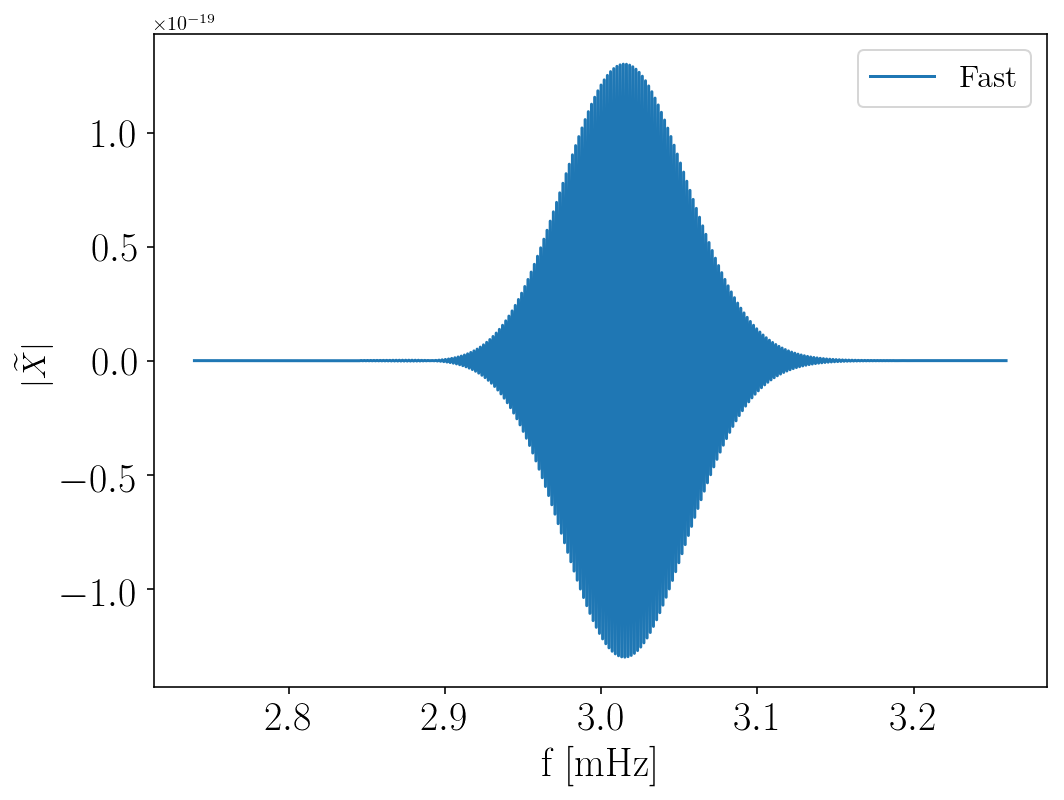

In [187]:
Week = 3600.*24.*7.
dt   = 15.
Tobs = 2**np.ceil(np.log2(Week/dt))*dt
orb = l.Orbit(Tobs, dt=dt)
t = np.arange(0.0, orb.Tobs, orb.dt) # set up the time of this orbit

A    = 2.0e-21
f0   = 3.0*mHz
tau  = 1.5*Hour
t0   = 0.5*orb.Tobs
phi0 = 1.0

theta = np.pi*0.23
phi   = np.pi*1.2
psi   = np.pi*0.2
ellip = 0.

# Non-Dimensional parameters
paramsND = np.array([np.log(A), f0/mHz, t0/Week, tau/Week, phi0, \
                     np.cos(theta), phi, psi, ellip])

gw = bu.Burst(paramsND, orb)
gw.construct_detector_tensor()
gw.calculate_strain()
gw.TDI = gw.construct_TDI(orb)

orb.x = orb.get_orbit(t)
orb.rij = orb.get_seps(t, orb.x)

mask = (t-t0 < orb.dt) & (t0-t < orb.dt)
ti = t[mask]
ti_idx = np.where(t == ti)[0][0]
print(ti)

# r12 = orb.rij[:,0,1,ti_idx]
# r13 = orb.rij[:,0,2,ti_idx]

R = (orb.x[:,0,ti_idx] + orb.x[:,1,ti_idx] + orb.x[:,2,ti_idx])/3

# plane_vec = np.cross(r12, r13)
# plane_vec /= np.sqrt(np.dot(plane_vec, plane_vec))
n_hat = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
# n_hatp = n_hat - 2*np.dot(n_hat, plane_vec)*plane_vec

n_hatp = np.copy(n_hat)
n_hatp[-1] = -n_hatp[-1]

thetap = np.arccos(n_hatp[-1])
phip = np.arctan2(n_hatp[1]/np.sin(thetap), n_hatp[0]/np.sin(thetap))

print(theta, phi)
print(thetap, phip)

# Non-Dimensional parameters
psi  = -psi
t0  += 2*np.dot(n_hat,R)/l.Clight 
paramsND = np.array([np.log(A), f0/mHz, t0/Week, tau/Week, phi0, \
                     np.cos(thetap), phip, psi, ellip])

gw_ref = bu.Burst(paramsND, orb)
gw_ref.construct_detector_tensor()
gw_ref.calculate_strain()
gw_ref.TDI = gw_ref.construct_TDI(orb)


fig, ax = plt.subplots(figsize=(8,6))

ax.set_xlabel(r'f [mHz]', fontsize=20)
ax.set_ylabel(r'$|\widetilde{X}|$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)

f = 1000*gw.TDI.freqs
ax.plot(f, gw.TDI.X.real - 1*gw_ref.TDI.X.real, label='Fast')

plt.legend(loc='upper right', fontsize=16)
plt.show()

In [147]:
np.dot(n_hat,R)/l.Clight

-286.5514844449278

In [4]:
import numpy as np
print(10**2/2)
test = np.geomspace(1,10**2/2,30)
print(test[19])

50.0
12.975326016911298
